# Insurance All

# Business Problem

Insurance All is a company that provides health insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: auto insurance.

As with health insurance, customers of this new auto insurance plan need to pay an amount annually to Insurance All to obtain an amount insured by the company, aimed at the costs of an eventual accident or damage to the vehicle.

Insurance All conducted a survey of about 380,000 customers about their interest in joining a new auto insurance product last year. All customers expressed interest or not in purchasing auto insurance and these responses were saved in a database along with other customer attributes.

The product team selected 127 thousand new customers who did not respond to the survey to participate in a campaign, in which they will receive the offer of the new auto insurance product. The offer will be made by the sales team through telephone calls.

However, the sales team has the capacity to make 20 thousand calls within the campaign period.

The challenge
In that context, it is necessary build a model that predicts whether or not the customer would be interested in auto insurance.

With its solution, the sales team hopes to be able to prioritize the people with the greatest interest in the new product and optimize the campaign by making only contacts with customers most likely to make the purchase.

As a result of the project, it is needed to deliver a report containing some analysis and answers to the following questions:

- Main Insights about the most relevant attributes of customers interested in purchasing auto insurance.

- What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?

- And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

- How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

# Data Base Credentials

- Database: Postgres 12.0 - AWS
- Credentials:
- HOST = comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com
- PORT=5432
- Database=comunidadedsdb
- Username=member
- Password=cdspa
- Presentation of PA004: https://docs.google.com/presentation/d/1gMo5xFPSvAEWsFGHyZKgLLQwzvg2lc65BSXuaLLmWyg/edit?usp=sharing
- Link for business probelm: https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

# Imports

In [1]:
# databse conmection
import psycopg2
from psycopg2 import OperationalError

# data manipulation
import pandas as pd

# data visualization
from matplotlib import pyplot as plt
import seaborn  as sns

# data analysis
from pandas_profiling import ProfileReport

# split dataset
from sklearn.model_selection import train_test_split

# Feature Selection
from boruta import BorutaPy

# machine learning
from xgboost              import XGBClassifier
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB
from imblearn.ensemble    import BalancedRandomForestClassifier
from catboost             import CatBoostClassifier

# metrcis
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, brier_score_loss, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve

# confusion matrix
from sklearn.metrics import plot_confusion_matrix

# threshold
from numpy import argmax

#fine tuning
from skopt import BayesSearchCV

# calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# cross validation
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold 

# display
from IPython.core.display import HTML

# save pickle objects
import pickle

# filter warnings


# Functions

In [2]:
###########################################################################################################################
    
# Machine Learning Performance
def ml_performance(models, x_train, y_train, x_valid, y_valid, threshold):
    model_df = []     
    for model in models:
        print("Training " + type(model).__name__ + "...")
        model.fit(x_train, y_train)
        
        # predict positive probabilities according to a threshold
        y_proba = model.predict_proba(x_valid)[:, 1]
        y_hat = (y_proba >= threshold).astype(int)
        
        # metrics
        f1 = f1_score(y_valid, y_hat)
        accuracy = accuracy_score(y_valid, y_hat)
        bal_accuracy = balanced_accuracy_score(y_valid, y_hat)
        kappa = cohen_kappa_score(y_valid, y_hat)
        roc_auc = roc_auc_score(y_valid, y_hat)
        precision = precision_score(y_valid, y_hat)
        recall = recall_score(y_valid, y_hat)
        brier = brier_score_loss(y_valid, y_hat, pos_label=1)
        
        metrics = pd.DataFrame({'Model Name': type(model).__name__,'Accuracy': accuracy, 'Bal Accuracy': bal_accuracy,
                                'Precision': precision,'Recall': recall,'F1-Score': f1,'ROC-AUC': roc_auc,'Kappa': kappa,
                                'Brier': brier}, index = [0]).sort_values('F1-Score', ascending = False)
        
        model_df.append(metrics)
        final_model = pd.concat(model_df)
    return final_model.sort_values(by='F1-Score', ascending=False).round(5)

###########################################################################################################################

# Confusion Matrix
def conf_matrix (model, x_train, y_train, x_valid, y_valid):
    model.fit(x_train, y_train)
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(model, x_valid, y_valid, cmap='magma_r', normalize='true', ax=ax)
    plt.title(type(model).__name__, size = 20)
    plt.xlabel("Predicted label", size=20)
    plt.ylabel("True label", size=20)
    plt.grid(False)
    
###########################################################################################################################
    
# Cross Validation
def cross_validation(models, X, y, cv):
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
        bal_accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='balanced_accuracy', n_jobs=-1)
        bal_accuracy = "{:.4f} +/- %{:.4f}".format(bal_accuracy_cv.mean(), bal_accuracy_cv.std())
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        
                
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Bal Accuracy (Avg+Std)': bal_accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_df = pd.concat(cv_df)

    return final_df
    
###########################################################################################################################

# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 25
    #display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()
    
###########################################################################################################################

Populating the interactive namespace from numpy and matplotlib


In [77]:
# function to test the conection
def create_connection(db_name, db_user, db_password, db_host, db_port):
    connection = None
    try:
        connection = psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port,
        )
        print("Connection to PostgreSQL DB successful")
    except OperationalError as e:
        print(f"The error '{e}' occurred")
    return connection

In [78]:
# test the conection
create_connection("comunidadedsdb", "member", "cdspa", "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com", "5432")

Connection to PostgreSQL DB successful


<connection object at 0x7fba81c3ed50; dsn: 'user=member password=xxx dbname=comunidadedsdb host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432', closed: 0>

In [3]:
# connect
conn = psycopg2.connect(database="comunidadedsdb",
                               user="member",
                               password="cdspa",
                               host="comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com",
                               port="5432")

cursor = conn.cursor()

In [4]:
# print the tables
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print(cursor.fetchall())

[('users',), ('vehicle',), ('insurance',)]


In [5]:
# import the tables
df_users = pd.read_sql("SELECT * FROM pa004.users", con=conn)
df_vehicle = pd.read_sql("SELECT * FROM pa004.vehicle", con=conn)
df_insurance = pd.read_sql("SELECT * FROM pa004.insurance", con=conn)

In [104]:
# show users dataset
df_users

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0
...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0
381105,381106,Male,30,37.0,152.0
381106,381107,Male,21,30.0,160.0
381107,381108,Female,68,14.0,124.0


In [105]:
# show vehicle dataset
df_vehicle

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No
...,...,...,...,...
381104,381105,1,1-2 Year,No
381105,381106,1,< 1 Year,No
381106,381107,1,< 1 Year,No
381107,381108,1,> 2 Years,Yes


In [106]:
# show insurance dataset
df_insurance

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0
...,...,...,...,...,...
381104,381105,1,30170.0,88,0
381105,381106,1,40016.0,131,0
381106,381107,1,35118.0,161,0
381107,381108,0,44617.0,74,0


In [6]:
# merge all datasets
df_raw = pd.merge( df_users, df_vehicle, how='inner', on='id' )
df_raw = pd.merge( df_raw, df_insurance, how='inner', on='id' )

In [191]:
pickle.dump(df_raw, open('data/df_raw.pkl', 'wb'))

In [7]:
df_insurance = None
df_users = None
df_vehicle = None

In [8]:
df_raw

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.00000,26.00000,1,> 2 Years,Yes,0,40454.00000,217,1
1,2,Male,76,3.00000,26.00000,1,1-2 Year,No,0,33536.00000,183,0
2,3,Male,47,28.00000,26.00000,1,> 2 Years,Yes,0,38294.00000,27,1
3,4,Male,21,11.00000,152.00000,1,< 1 Year,No,1,28619.00000,203,0
4,5,Female,29,41.00000,152.00000,1,< 1 Year,No,1,27496.00000,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.00000,26.00000,1,1-2 Year,No,1,30170.00000,88,0
381105,381106,Male,30,37.00000,152.00000,1,< 1 Year,No,1,40016.00000,131,0
381106,381107,Male,21,30.00000,160.00000,1,< 1 Year,No,1,35118.00000,161,0
381107,381108,Female,68,14.00000,124.00000,1,> 2 Years,Yes,0,44617.00000,74,0


# Dataset Information

#### Columns

- Id: Customer ID
- Gender: Customer Age
- Region Code: The code of the region that customer lives
- Policy Sales Channel: The code for the customer disclosure channel (mail, phone, agents, etc.)
- Driving License: Customer has a license 1; customer has no license 0
- Vehicle Age: The age of the vehicle
- Vehicle Damage: If the vehicle has been damaged in the past, yes or no
- Previously Insured: If the customer has a previous insurance, no: 0, yes: 1
- Annual Premium: How much the customer paid the company for annual health insurance
- Vintage: Number of days the customer joined the company through the purchase of health insurance.
- Response: The customer has interest in buy the car insurance, no: 0, yes: 1

#### The dataset has 381109 rows × 12 columns

# Dataset Analysis

In [22]:
profile = ProfileReport(df_raw, title='Insurance_All')
profile.to_file(output_file='Insurance_All')

### According to Pandas Profile Report it can be highlighted the following Key Points:

#### - The data set has no missing cells or duplicate rows.
#### - There are more men (54.1%) than women (45.9%)
#### - The age ranges from 20 to 85 years. The average age is 38 years and the distribution is positively skewed (0.67). There is a peak at the ages of 23 and 24, both representing 13.2% of all ages.
#### - The most common region code is 28, representing 27.9% of all 53 codes.
#### - The most common policy sales channel are 152 (35.4%), 26 (20.9%) and 124 (19.4%).
#### - Most customers have a driver's license (99.8%)
#### - Most vehicles are between 1 and 2 years old (52.6%), followed by vehicles under 1 year old (43.2%) and over 2 years old (4.2%)
#### - Most vehicles were damaged (50.5%)
#### - Most customers have already been assured (54.2%)
#### - The average of annual premium is 30564, in addition to a minimum of 2630 and a maximum of 540165. The distribution is highly skewed (1.76) and has a kurtosis of 34, which implies that there are many outliers and data is concentrated at the beginning of the curve.
#### - The target variable (response) is quite unbalanced, since 87.7% of customers answered "no" to a new auto insurance proposal.

# Encoding

In [24]:
df1 = pickle.load(open('data/df_raw.pkl', 'rb'))

In [25]:
# label enconding
df1["gender"] = df1["gender"].apply(lambda x: 0 if x == 'Male' else 1).astype(int)
df1["vehicle_damage"] = df1["vehicle_damage"].apply(lambda x: 0 if x == 'No' else 1).astype(int)

# ordinal enconding
df1["vehicle_age"] = df1["vehicle_age"].apply(lambda x: 0 if x == '< 1 Year' else 1 if x == '1-2 Year' else 2).astype(int)

In [26]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,1,44,28.00000,26.00000,1,2,1,0,40454.00000,217,1
1,2,1,76,3.00000,26.00000,1,2,1,0,33536.00000,183,0
2,3,1,47,28.00000,26.00000,1,2,1,0,38294.00000,27,1
3,4,1,21,11.00000,152.00000,1,2,1,1,28619.00000,203,0
4,5,1,29,41.00000,152.00000,1,2,1,1,27496.00000,39,0


In [33]:
# save dataset
pickle.dump( df1, open( 'data/df1.pkl', 'wb' ) )

#  Boruta Feature Selection

In [34]:
# load dataset
df2 = pickle.load( open( 'data/df1.pkl', 'rb' ) )

In [199]:
# split into x and y
x = df_raw.drop(['id', 'response'], axis=1).copy()
y = df_raw['response'].copy()

In [200]:
# Using Classifiers with all CPU cores
rf = RandomForestClassifier(n_jobs=-1)
extra = ExtraTreesClassifier(n_jobs=-1)
xgb = XGBClassifier(random_state=28)
brfc = BalancedRandomForestClassifier(random_state=28)

## Boruta using Random Forest Regressor

In [201]:
# Boruta using Random Forest Regressor
boruta = BorutaPy(rf, n_estimators='auto', verbose=False, random_state=28).fit(x.values, y.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

[]

## Boruta using Extra Trees Classifier

In [202]:
# Boruta using Extra Trees Classifier
boruta = BorutaPy(extra, n_estimators='auto', verbose=False, random_state=28).fit(x.values, y.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age']

## Boruta using XGBoost Classifier

In [203]:
# Boruta using XGBoost Classifier
boruta = BorutaPy(xgb, n_estimators='auto', verbose=False, random_state=28).fit(x.values, y.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

[04:32:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:32:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:33:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

['gender',
 'age',
 'region_code',
 'policy_sales_channel',
 'driving_license',
 'vehicle_age',
 'vehicle_damage',
 'previously_insured',
 'annual_premium']

## Boruta using Balanced Random Forest Classifier

In [204]:
# Boruta using Balanced Random Forest Classifier
boruta = BorutaPy(brfc, n_estimators='auto', verbose=False, random_state=28).fit(x.values, y.values.ravel())

# Columns Selected by Boruta using Random Forest Regressor
cols_selected = boruta.support_.tolist()
cols_selected_boruta = x.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'vehicle_damage', 'previously_insured']

### Based on the analysis of the correlations of all variables observed in the Pandas Profile Report, Boruta's results using the Balanced Random Forest Classifier are the most consistent.

# Split into train (70%), validation (10%) and test (20%)

In [205]:
# load dataset
df_raw = pickle.load(open('data/df_raw.pkl', 'rb'))

In [206]:
# split into x and y
x = df_raw.drop(['id', 'response'], axis=1).copy()
y = df_raw['response'].copy()

In [207]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=28, stratify=y)

# train valid split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=28)

# check balance of classes (0, 1) among y_train, y_test and y_valid
print(f"y_train size: {np.bincount(y_train)}")
print(f"y_test size: {np.bincount(y_test)}")
print(f"y_valid size: {np.bincount(y_valid)}")

y_train size: [240862  33536]
y_test size: [66880  9342]
y_valid size: [26657  3832]


In [208]:
# shape of trains, tests and valids
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(274398, 10)
(30489, 10)
(76222, 10)
(274398,)
(30489,)
(76222,)


In [209]:
# saving all data
pickle.dump(x_train, open('data/x_train.pkl', 'wb'))
pickle.dump(x_test, open('data/x_test.pkl', 'wb'))
pickle.dump(x_valid, open('data/x_valid.pkl', 'wb'))

pickle.dump(y_train, open('data/y_train.pkl', 'wb'))
pickle.dump(y_test, open('data/y_test.pkl', 'wb'))
pickle.dump(y_valid, open('data/y_valid.pkl', 'wb'))

pickle.dump(x, open('data/x.pkl', 'wb'))
pickle.dump(y, open('data/y.pkl', 'wb'))

# Machine Learning

In [210]:
# load all data
x_train = pickle.load(open('data/x_train.pkl', 'rb'))
x_valid = pickle.load(open('data/x_valid.pkl', 'rb'))
x_test = pickle.load(open('data/x_test.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))
y_valid = pickle.load(open('data/y_valid.pkl', 'rb'))
y_test = pickle.load(open('data/y_test.pkl', 'rb'))

In [211]:
# algorithms
models = [CatBoostClassifier(random_state=28, verbose=False),
          XGBClassifier(random_state=28),
          LGBMClassifier(random_state=28, n_jobs=-1),
          LogistcRegression(max_iter=220, random_state=28),
          RandomForestClassifier(random_state=28),
          BalancedRandomForestClassifier(random_state=28),
          KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
          SGDClassifier(loss='log', random_state=28, n_jobs=-1), 
          GaussianNB()]

ml_performance(models, x_train, y_train, x_valid, y_valid, 0.50)

Training CatBoostClassifier...
Training XGBClassifier...
[04:43:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training BalancedRandomForestClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training GaussianNB...


,Model Name,Accuracy,Bal Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.70573,0.79496,0.28841,0.91414,0.43848,0.79496,0.30583,0.29427
0,GaussianNB,0.81915,0.62118,0.30956,0.35673,0.33147,0.62118,0.22751,0.18085
0,RandomForestClassifier,0.86379,0.55185,0.38172,0.13518,0.19965,0.55185,0.14334,0.13621
0,KNeighborsClassifier,0.85231,0.51948,0.23052,0.07490,0.11306,0.51948,0.05479,0.14769
0,LogisticRegression,0.87110,0.51984,0.39918,0.05063,0.08986,0.51984,0.06336,0.12890
0,CatBoostClassifier,0.87363,0.51514,0.46488,0.03627,0.06730,0.51514,0.05001,0.12637
0,XGBClassifier,0.87330,0.51014,0.43049,0.02505,0.04735,0.51014,0.03400,0.12670
0,LGBMClassifier,0.87372,0.50056,0.23529,0.00209,0.00414,0.50056,0.00193,0.12628
0,SGDClassifier,0.87179,0.49900,0.04706,0.00104,0.00204,0.49900,-0.00343,0.12821


## Test with columns from feature selection

In [212]:
# load dataset
df_raw = pickle.load( open( 'data/df_raw.pkl', 'rb' ) )

In [213]:
# split into x and y
x = df_raw[['age', 'vehicle_damage', 'previously_insured']]
y = df_raw['response']

In [214]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=28, stratify=y)

# train valid split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=28)

In [215]:
# algorithms
models = [CatBoostClassifier(random_state=28, verbose=False),
          XGBClassifier(random_state=28),
          LGBMClassifier(random_state=28, n_jobs=-1),
          LogisticRegression(max_iter=220, random_state=28),
          RandomForestClassifier(random_state=28),
          BalancedRandomForestClassifier(random_state=28),
          KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
          SGDClassifier(loss='log', random_state=28, n_jobs=-1), 
          GaussianNB()]

ml_performance(models, x_train, y_train, x_valid, y_valid, 0.50)

Training CatBoostClassifier...
Training XGBClassifier...
[04:45:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training BalancedRandomForestClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training GaussianNB...


,Model Name,Accuracy,Bal Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.68166,0.79326,0.27573,0.94233,0.42663,0.79326,0.28821,0.31834
0,GaussianNB,0.64210,0.78628,0.25723,0.97886,0.40741,0.78628,0.26013,0.35790
0,KNeighborsClassifier,0.84601,0.57811,0.33085,0.22025,0.26445,0.57811,0.18231,0.15399
0,CatBoostClassifier,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568
0,XGBClassifier,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568
0,LGBMClassifier,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568
0,LogisticRegression,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568
0,RandomForestClassifier,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568
0,SGDClassifier,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568


## As can be seen the difference is small, so it is possible to use just three variables as features for predictions. However, for now, it will be used all the features to maximize results.

# Confusion Matrix of Default Balanced Random Forest

In [220]:
# load all data
x_train = pickle.load(open('data/x_train.pkl', 'rb'))
x_valid = pickle.load(open('data/x_valid.pkl', 'rb'))
x_test = pickle.load(open('data/x_test.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))
y_valid = pickle.load(open('data/y_valid.pkl', 'rb'))
y_test = pickle.load(open('data/y_test.pkl', 'rb'))

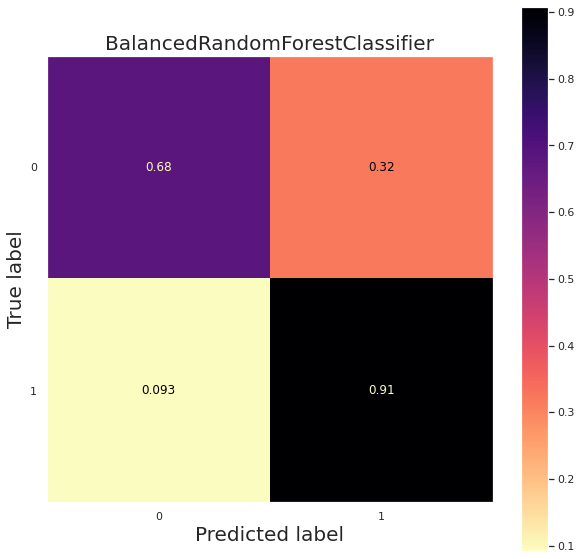

In [221]:
conf_matrix(BalancedRandomForestClassifier(random_state=28), x_train, y_train, x_valid, y_valid)

# Classification Report of BRFC

In [224]:
brfc = BalancedRandomForestClassifier(random_state=28).fit(x_train, y_train)

# predictions
y_brfc = brfc.predict(x_valid)

# prints
print(type(brfc).__name__)
print(classification_report(y_valid, y_brfc))

BalancedRandomForestClassifier
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     26657
           1       0.29      0.91      0.44      3832

    accuracy                           0.71     30489
   macro avg       0.64      0.79      0.62     30489
weighted avg       0.89      0.71      0.76     30489



# Best Threshold for ROC AUC

Best Threshold=0.530000, G-Mean=0.786


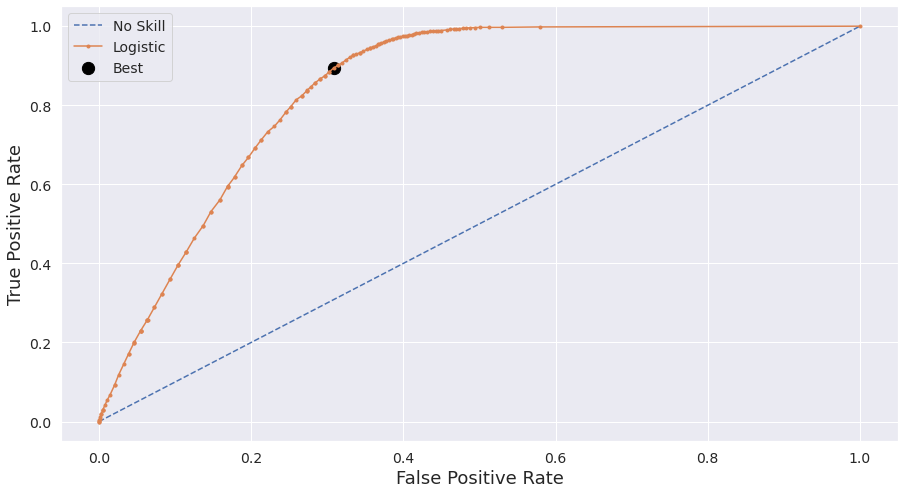

In [251]:
# model
brfc = BalancedRandomForestClassifier(random_state=28).fit(x_train, y_train)

# predict probabilities and get the positive outcome only
brfc_yhat = brfc.predict_proba(x_valid)

# keep probabilities for the positive outcome only
brfc_yhat = brfc_yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_valid, brfc_yhat)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.yticks(size=14)
plt.xticks(size=14)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', s=150, label='Best')
plt.xlabel('False Positive Rate',size =18)
plt.ylabel('True Positive Rate', size =18)
plt.legend(prop={'size': 14})
plt.show()

## Performance with best ROC Curve threshold

In [245]:
models = [BalancedRandomForestClassifier(random_state=28)]

ml_performance(models, x_train, y_train, x_valid, y_valid, 0.53)

Training BalancedRandomForestClassifier...


,Model Name,Accuracy,Bal Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.71705,0.79294,0.29419,0.89431,0.44274,0.79294,0.31274,0.28295


# Best Threshold for Precision Recall Curve

Best Threshold=0.980000, F1-Score=nan


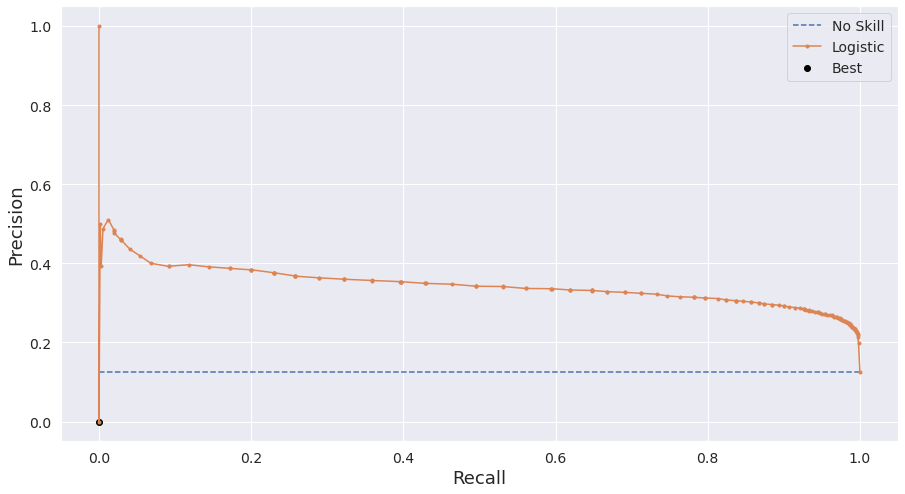

In [268]:
# model
brfc = BalancedRandomForestClassifier(random_state=28).fit(x_train, y_train)

# predict probabilities and get the positive outcome only
brfc_yhat = brfc.predict_proba(x_valid)

# keep probabilities for the positive outcome only
brfc_yhat = brfc_yhat[:, 1]

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_valid, brfc_yhat)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F1-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.yticks(size=14)
plt.xticks(size=14)
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
plt.xlabel('Recall',size =18)
plt.ylabel('Precision', size =18)
plt.legend(prop={'size': 14})
plt.show()

## Performance with best Precision Recall Curve threshold

In [275]:
# algorithm
models = [BalancedRandomForestClassifier(random_state=28)]

ml_performance(models, x_train, y_train, x_valid, y_valid, 0.98)

Training BalancedRandomForestClassifier...


,Model Name,Accuracy,Bal Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.87422,0.49994,0.00000,0.00000,0.00000,0.49994,-0.00020,0.12578


# Hyperparameter Fine Tuning

In [279]:
x_train = pickle.load( open( 'data/x_train.pkl', 'rb' ) )
y_train = pickle.load( open( 'data/y_train.pkl', 'rb' ) )

## Bayes Search

In [293]:
#Using BayesSearchCV
brfc = BalancedRandomForestClassifier(random_state=28)
params = {'n_estimators': [10,25,50,80,100,150,200,400,500,700,800,1000,1500,1700,2500,3000,3500],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,20,30,50,80,100,200,300,400,500,800,1000],
          'min_samples_leaf': [2,3,4,5,6,7,8,9,10,20,30,50,80,100,200,300,400,500,800,1000],
          'max_features': ['auto','sqrt','log2'],
          'max_depth' : [3,4,5,6,7,8,10,12,15,20,25,30,50,80,100],
          'criterion' :['gini', 'entropy'],
          'min_impurity_decrease': [0,1,2,3,4,5,6,7,8,9,10,20,30,40,50],
          'replacement': [True, False],
          'max_samples': [1,2,3,4,5,6,7,8,9,10,20,30,50,80,100,200,300,400,500,800,1000,1500,1700,2500,3000,3500]}

bayes_brfc = BayesSearchCV(estimator=brfc, search_spaces=params, cv=2, n_jobs=-1)
bayes_brfc.fit(x_train, y_train)

# Results from Grid Search
print("Results from Bayes Search" )
print("\n The best estimator across ALL searched params:\n",bayes_brfc.best_estimator_)
print("\n The best score across ALL searched params:\n",bayes_brfc.best_score_)
print("\n The best parameters across ALL searched params:\n",bayes_brfc.best_params_)

Results from Bayes Search

 The best estimator across ALL searched params:
 BalancedRandomForestClassifier(max_depth=50, max_samples=3500,
                               min_impurity_decrease=20, min_samples_leaf=10,
                               min_samples_split=400, random_state=28)

 The best score across ALL searched params:
 0.8777833657679721

 The best parameters across ALL searched params:
 OrderedDict([('criterion', 'gini'), ('max_depth', 50), ('max_features', 'auto'), ('max_samples', 3500), ('min_impurity_decrease', 20), ('min_samples_leaf', 10), ('min_samples_split', 400), ('n_estimators', 100), ('replacement', False)])


# Tuned Model Performance

In [302]:
# algorithm
models = [BalancedRandomForestClassifier(criterion='gini', max_depth=50, max_features='auto',
                                            max_samples=3500, min_impurity_decrease=20,
                                            min_samples_leaf=10, min_samples_split=400,
                                            n_estimators=100, replacement=False, random_state=28)]

ml_performance(models, x_train, y_train, x_valid, y_valid, 0.53)

Training BalancedRandomForestClassifier...


,Model Name,Accuracy,Bal Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.87432,0.50000,0.00000,0.00000,0.00000,0.50000,0.00000,0.12568


# Confusion Matrix of Tuned Balanced Random Forest 

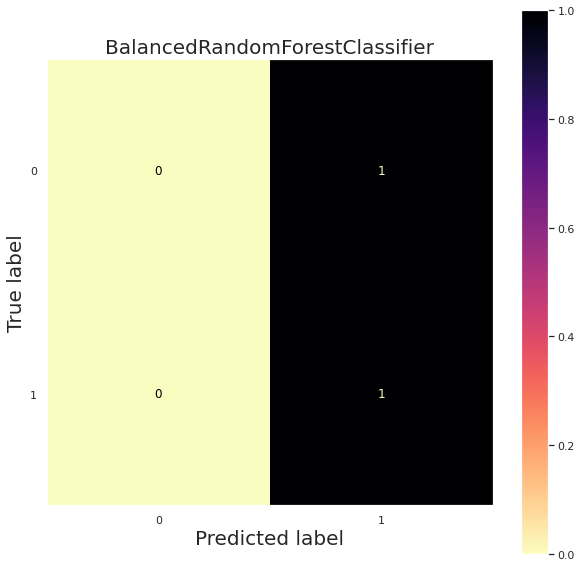

In [303]:
brfc = BalancedRandomForestClassifier(criterion='gini', max_depth=50, max_features='auto',
                                            max_samples=3500, min_impurity_decrease=20,
                                            min_samples_leaf=10, min_samples_split=400,
                                            n_estimators=100, replacement=False, random_state=28)

conf_matrix(brfc, x_train, y_train, x_valid, y_valid)

# Calibration

In [301]:
# balanced random forest tuned
brfc_tuned = BalancedRandomForestClassifier(criterion='gini', max_depth=50, max_features='auto',
                                            max_samples=3500, min_impurity_decrease=20,
                                            min_samples_leaf=10, min_samples_split=400,
                                            n_estimators=100, replacement=False, random_state=28)

# wrap the model
calibrated = CalibratedClassifierCV(brfc_tuned)

# define grid
param_grid = dict(cv=[2,3,4,5], method=['sigmoid','isotonic'])

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=28)

# define grid search
grid = GridSearchCV(estimator=calibrated, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

# execute the grid search
grid_result = grid.fit(x_valid, y_valid)

# report the best configuration
print("Best F1-Score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best F1-Score: 0.000000 using {'cv': 2, 'method': 'sigmoid'}
0.000000 (0.000000) with: {'cv': 2, 'method': 'sigmoid'}
0.000000 (0.000000) with: {'cv': 2, 'method': 'isotonic'}
0.000000 (0.000000) with: {'cv': 3, 'method': 'sigmoid'}
0.000000 (0.000000) with: {'cv': 3, 'method': 'isotonic'}
0.000000 (0.000000) with: {'cv': 4, 'method': 'sigmoid'}
0.000000 (0.000000) with: {'cv': 4, 'method': 'isotonic'}
0.000000 (0.000000) with: {'cv': 5, 'method': 'sigmoid'}
0.000000 (0.000000) with: {'cv': 5, 'method': 'isotonic'}


# Cross Validation

In [279]:
x_train = pickle.load(open('data/x_train.pkl', 'rb'))
x_valid = pickle.load(open('data/x_valid.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))
y_valid = pickle.load(open('data/y_valid.pkl', 'rb'))

In [312]:
# concat
X = pd.concat([x_train, x_valid], axis = 0)
y = pd.concat([y_train, y_valid], axis = 0)

model = [BalancedRandomForestClassifier(random_state=28)]

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=28)

# cross validation
cross_validation(model, X, y, cv)

,Model Name,Accuracy (Avg+Std),Bal Accuracy (Avg+Std),Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std)
0,BalancedRandomForestClassifier,0.1226 +/- %0.0000,0.5000 +/- %0.0000,0.1226 +/- %0.0000,1.0000 +/- %0.0000,0.2184 +/- %0.0000,0.5000 +/- %0.0000


## The tuned model is overfitting 